# CS 696 - Final Project 
<b> Travis Klipp and Briana Ramirez 

This script contains additional analysis about the Reconstructed precipitation data set. The below analysis will help us understand the story the data is trying to tell. One thing to notice about the data is the following, it was created from a multivariate reconstruction technique that ultized SVD to estimate precipitation values from a sparse dataset. This dataset contains historical estimates of the precipatation anamolies that have occured between the years of 1980 to 2014. Another note about the dataset, negitive values of precipatation corresond with a measurement of dryness in the air. THis measuremnt was not used to recored values untill 2008. 

This script will analyze the following items:

    1.Weather Anomaly Analysis
        a.Count weather anomalies
        b.Look at trends over time.
        c.Precip has evolution for California
    2.Week Day Analysis
        a.Sums, Mean, STD, Variance, Minimum, and Maximum
    3. Week Analysis
        a. Min and Max 
    4.Precipitation at SDSU.
        b.Line plot of precip
        c.Descriptive stats at SDSU
    5.Month Analysis
        a.Sums, Mean, STD, Variance, Minimum, and Maximum
    6.Precipitation in San Diego. 
        a.Descriptive stats of San diego 
        b.Line plot of mean precip in SD
    7.Visualization of US Storms and Floods
        a.Texas Storm 1998
        b.Hurricane Katrina 2005
        c.Hurricane Andrew 1992

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as stat
import pyspark as ps 
import vaex
import seaborn as sns
import time
import math as m
from datetime import timedelta, date, datetime
import matplotlib
from mpl_toolkits.basemap import Basemap
from pylab import rc 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px
from matplotlib import cm
from sklearn.linear_model import Ridge

ERROR:MainThread:vaex:issue loading reader
Traceback (most recent call last):
  File "/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/vaex/__init__.py", line 720, in <module>
    add_namespace = entry.load()
  File "/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2442, in load
    self.require(*args, **kwargs)
  File "/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2465, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  File "/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 791, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.VersionConflict: (pyarrow 0.12.1 (/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages), Requirement.parse('pyarrow>=0.15'))


# Data Upload and Cleaning 

Load the data and limit data to values within US borders. 

In [2]:
#load US mask
check_file = '/Volumes/BMR-HardDrive/ScottKnapp20190308-DailyReconCONUS/check.txt'
check=open(check_file,'r')
check=check.readlines()

#Graabing only value_strings in check list
check = check[0::2]

#Converting value_strings to floats 
check = [float(x) for x in check]

#Making a boolean list from check list that only contains {0,1}
#false : not in US
#true: in US territory 
check_bool = list(map(bool,check))

#Reading in reconconstructed data 
data_file = '/Volumes/BMR-HardDrive/ScottKnapp20190308-DailyReconCONUS/Reconstruction/recon8014EOF220.csv'
recon=pd.read_csv(data_file)
colnames=list(recon.columns) #get colnames for later

#Array of column names 
colnames=np.array(colnames)

#lose col names
recon2=np.array(recon)

#List of positions of values 
x = []
for i in range(len(check_bool)):
    if check_bool[i] == True:
        x.append(i)

#grabbing recon values that are in US mask, namely check_bool
recon3=recon2[x,:] 

In [3]:
recon3.shape

(13278, 12787)

Supressing values to [0,500] scale

In [4]:
#In the reconstuction technique, some values are extrapolated to far away from reality. 
#Supressing values between [0,500] allows for more reasonable approximations. 
for i in list(range(3,12787)):
    for j in list(range(0,13278)):
        if recon3[j,i] <= 0:
            recon3[j,i] = 0
        elif recon3[j,i] >= 500:
            recon3[j,i] = 500

# Weather Anomaly Analysis

<b> This data set was created in order to allow climatologists to predict weather anomalies before they happen for better preparedness of weather catastrophes. A weather anomaly is said to be occurring if precipitation values are above 50 mm a day. Due to the fact that this is reconstructed precipitation data, we will raise the weather anomaly minimum precipitaion to 75mm per day. 

<b>Percent of Weather Anomalies

In [5]:
max_per_day = recon3.max(axis=0)
a_pos = np.where(max_per_day >= 75)
my_per = round(len(colnames[a_pos])/len(max_per_day)*100,1)
print("From the years 1980 to 2014,", my_per, "% of the total days had precipitation levels that were higher than 75mm",
      "\n per day, which is indication for a Weather Anomaly occuring.")

From the years 1980 to 2014, 17.9 % of the total days had precipitation levels that were higher than 75mm 
 per day, which is indication for a Weather Anomaly occuring.


<b>Weather Anomalies Trend over Time

In [6]:
#Not Considering the change in leap years 
yr_avg = []
y=0
for i in range(35):
    x = recon3[:,3+y:368+y].mean()
    yr_avg.append(x)
    y = y + 365
x = np.linspace(1980,2014,35)
mean_yr_df = pd.DataFrame({"Year_Avg":yr_avg}, index = x)

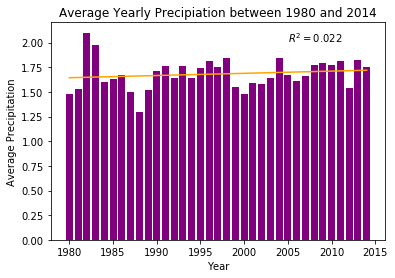

In [7]:
y = mean_yr_df.index.values
plt.bar(y,mean_yr_df.Year_Avg, facecolor="purple")
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.title("Average Yearly Precipiation between 1980 and 2014")

lr = Ridge()

lr.fit(y.reshape(-1, 1), mean_yr_df.Year_Avg)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

plt.plot(y, lr.coef_*y+lr.intercept_, color='orange')
plt.text(2005,2,"$R^2 = 0.022$")

plt.show()

We can see from the fitted Ridge line that there hasn't been a large change in average percipitation throughout the years we are observing. In all actuallity the slope of the model is nearly 0, with a reporting $R^2$ value of 0.022, we can conclude that there hasnot been a significant change in precipitation.  

In [8]:
print("R^2:",lr.score(y.reshape(-1, 1), mean_yr_df.Year_Avg), "-- Beta:", lr.coef_[0])

R^2: 0.022026846594838112 -- Beta: 0.0022349205006091727


In [9]:
extrapo = np.array([2015,2016,2017,2018,2019,2020])
predict = lr.predict(extrapo.reshape(-1,1))
[round(i,3) for i in predict]

[1.722, 1.725, 1.727, 1.729, 1.731, 1.734]

If we were to extrapolate on this model for the years 2015-2020, we get the estimated average precipitation values as follows:
    
       2015 - 1.722
       2016 - 1.725
       2017 - 1.727
       2018 - 1.729
       2019 - 1.731
       2020 - 1.734
       
From these values we can see that our model is averaging an increase of 0.003 in precipitation for every additional year. 

<b> Evolution of precipitation in Californa

In [10]:
ca_grid = np.where((recon3[:,1] >= 32.625) & (recon3[:,1] <= 41.875) &
                  (recon3[:,2] >= -124.125) & (recon3[:,2] <= -114.675))[0]
ca = recon3[[ca_grid],3:]

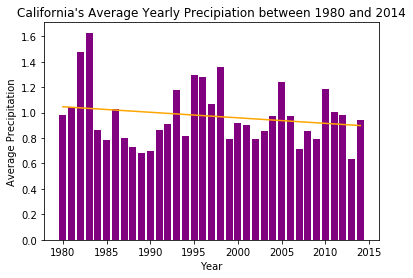

In [11]:
yr_avg = []
y=0
for i in range(35):
    x = ca[0][:,y:365+y].mean()
    yr_avg.append(x)
    y = y + 365
x = np.linspace(1980,2014,35)
mean_yr_df = pd.DataFrame({"Year_Avg":yr_avg}, index = x)
y = mean_yr_df.index.values
plt.bar(y,mean_yr_df.Year_Avg, facecolor="purple")
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.title("California's Average Yearly Precipiation between 1980 and 2014")

lr = Ridge()

lr.fit(y.reshape(-1, 1), mean_yr_df.Year_Avg)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

plt.plot(y, lr.coef_*y+lr.intercept_, color='orange')

plt.show()

In [12]:
print("We can see a downward trend for California's precipitation values. This model reported an $R^2$ value of",
     round(lr.score(y.reshape(-1, 1), mean_yr_df.Year_Avg),2)
      , "and has a slope of", round(lr.coef_[0],4)
      , ",thus confirming that precipitation has decreased throughout the observed years.")

We can see a downward trend for California's precipitation values. This model reported an $R^2$ value of 0.04 and has a slope of -0.0044 ,thus confirming that precipitation has decreased throughout the observed years.


# Week Day Analysis

In [13]:
week_days = ["Tu","Wed","Thurs","Fri","Sat","Sun","Mon"]
days = list(week_days for x in range(len(colnames)))
days = np.hstack(days)
header = [np.nan, np.nan, np.nan]
days = header + list(days)
day = days[:len(colnames)]
day = pd.Series(day)

Extracting unique day data.

In [14]:
week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
mon_pos = np.where(day == "Mon")
tue_pos = np.where(day == "Tu")
wed_pos = np.where(day == "Wed")
th_pos = np.where(day == "Thurs")
fri_pos = np.where(day == "Fri")
sat_pos = np.where(day == "Sat")
sun_pos = np.where(day == "Sun")

day_pos = [mon_pos,tue_pos,wed_pos,th_pos,fri_pos,sat_pos,sun_pos]
day_sum = []
day_mean = []
day_std = []
day_var = []
day_min = []
day_max = []

for i in day_pos:
    day_sum.append(recon3[:,i].sum())
    day_mean.append(recon3[:,i].mean())
    day_std.append(recon3[:,i].std())
    day_var.append(recon3[:,i].var())
    day_min.append(recon3[:,i].min())
    day_max.append(recon3[:,i].max())

day_df = pd.DataFrame({"Sum":day_sum,
                        "Mean":day_mean,
                        "Standard_Dev": day_std,
                        "Variance":day_var,
                        "Minimum":day_min,
                        "Maximum":day_max}, index=week_day)

In [15]:
day_df

,Sum,Mean,Standard_Dev,Variance,Minimum,Maximum
Monday,4.106665e+07,1.693776,5.223140,27.281190,0.0,500.000000
Tuesday,4.103094e+07,1.691376,5.182087,26.854027,0.0,500.000000
Wednesday,4.101279e+07,1.690628,5.180212,26.834601,0.0,500.000000
Thursday,4.079857e+07,1.682719,5.144908,26.470073,0.0,428.746598
Friday,4.126466e+07,1.701942,5.150263,26.525208,0.0,358.894902
Saturday,4.041950e+07,1.667084,5.095502,25.964140,0.0,449.923382
Sunday,3.996988e+07,1.648540,5.036683,25.368179,0.0,355.797910


In [16]:
print(day_df.max(), "\n",day_df.min())

Sum             4.126466e+07
Mean            1.701942e+00
Standard_Dev    5.223140e+00
Variance        2.728119e+01
Minimum         0.000000e+00
Maximum         5.000000e+02
dtype: float64 
 Sum             3.996988e+07
Mean            1.648540e+00
Standard_Dev    5.036683e+00
Variance        2.536818e+01
Minimum         0.000000e+00
Maximum         3.557979e+02
dtype: float64


<b> The day of the week that has: </b>

    (a) the largest overall precipitation is Friday.
    (b) the largest mean precipitation is Friday.
    (c) the largest standard deviation is Monday.
    (d) the largest variance is Monday.
    (e) the largest maximum precipitation values are Monday, Tuesday, and Wednesday. 
    
    (f) the smallest overall precipitation is Sunday.
    (g) the smallest mean precipitation is Sunday.
    (h) the smallest standard deviation is Sunday.
    (i) the smallest variance is Sunday.
    (j) the smallest maximum precipitation is Sunday. 
 

# Week Analysis

In [44]:
weeks = []
for i in range(1,53):
    for j in range(7):
        weeks.append(i)
wks = list(weeks for x in range(len(colnames)))
wks = np.hstack(wks)
header = [np.nan, np.nan, np.nan]
wks = header + list(wks)
wk = wks[:len(colnames)]
wk = pd.Series(wk)

In [88]:
weekly_data = []
weekly_df = {}
for i in range(1,53):
    pos = np.where(wk == i)
    weekly_df[i] = round(recon3[:,pos].mean(),2)
wdf = pd.DataFrame.from_dict(weekly_df, orient='index')
wdf = wdf.rename({0:"Average"}, axis='columns')
wdf.Average.sort_values(ascending=False).head(5)

28    2.08
24    2.06
27    2.01
39    1.99
31    1.98
Name: Average, dtype: float64

Weeks 28, 24, 27, 39, and 31 reported the highest weekly day averages. Meaning that these averages are what we could expect daily in a certain week. These weeks correspond with the month of June (week 28 and 24), mid july (week 27 and 31), and late September (week 39). We would expect to see more precipitation in the winter and fall months which could be indication that the reconstruction method used to build the data is modifying precipiation values to much. 

In [89]:
wdf.Average.sort_values().head(5)

50    1.21
8     1.21
3     1.23
52    1.28
6     1.31
Name: Average, dtype: float64

Weeks 50,8,3,52, and 6 reported the lowest recorded precipitation levels thoughput the observed years. Notice how all of these weeks are in Winter time, late december to early Febuary.

# Precipitation at SDSU

<b>Descriptive Statistics of Precipitation at SDSU 

In [17]:
sdsu_pos = 1487
sdsu_precip = recon3[sdsu_pos,3:]
sm = max(sdsu_precip)
x = np.where(sdsu_precip == sm)[0][0]
dm = colnames[x]
print("The maximum precipitation at SDSU is", sm, "mm and happened on", dm ,".")
sm = np.mean(sdsu_precip)
print("The mean precipitation at SDSU is", sm,"mm.")
sm = np.std(sdsu_precip)
print("The standard deviation of precipitation at SDSU is", sm,"mm.")
sm = np.median(sdsu_precip)
print("The median precipitation at SDSU is", sm,"mm.")
sm = min(sdsu_precip)
x = np.where(sdsu_precip == sm)[0]
dm = len(x)
print("The minimum precipitation at SDSU is", sm, "mm and happened", dm ,"days between the years of 1980-2014.")

The maximum precipitation at SDSU is 37.9224327889721 mm and happened on 2005-01-07 .
The mean precipitation at SDSU is 0.6667141160322536 mm.
The standard deviation of precipitation at SDSU is 1.8711926648551318 mm.
The median precipitation at SDSU is 0.0 mm.
The minimum precipitation at SDSU is 0.0 mm and happened 7565 days between the years of 1980-2014.


<b>Precipitation at SDSU throughout time. 

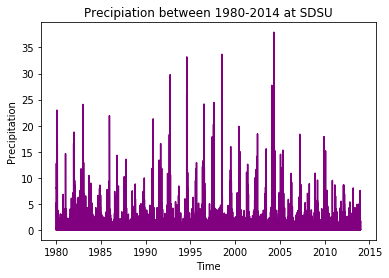

In [18]:
#index 1478 is approximatly SDSU coordinates 
x = np.linspace(1980,2014,12784)
plt.plot(x,recon3[1487,3:],ls="-",color='purple' )
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title("Precipiation between 1980-2014 at SDSU")
plt.show()

This plot allows us to see that the precipitation levels are decreasing at SDSU. In 2005, we can see the highest recored precipation values, followed by a decrease that keeps on decreasing. Overall, SDSU hasn't experienced precipation levels even half as what was seen in 2005 in over 10 years.

# Month Analysis 

Finding column position for days in the same month.

In [19]:
dec = [re.search("-12-",i) for i in colnames]
pos_dec = [i for i in range(len(dec)) if dec[i] != None]

nov = [re.search("-11-",i) for i in colnames]
pos_nov = [i for i in range(len(nov)) if nov[i] != None]

octo = [re.search("-10-",i) for i in colnames]
pos_oct = [i for i in range(len(octo)) if octo[i] != None]

sept = [re.search("-09-",i) for i in colnames]
pos_sept = [i for i in range(len(sept)) if sept[i] != None]

aug = [re.search("-08-",i) for i in colnames]
pos_aug = [i for i in range(len(aug)) if aug[i] != None]

jul = [re.search("-07-",i) for i in colnames]
pos_jul = [i for i in range(len(jul)) if jul[i] != None]

jun = [re.search("-06-",i) for i in colnames]
pos_jun = [i for i in range(len(jun)) if jun[i] != None]

may = [re.search("-05-",i) for i in colnames]
pos_may = [i for i in range(len(may)) if may[i] != None]

apr = [re.search("-04-",i) for i in colnames]
pos_apr = [i for i in range(len(apr)) if apr[i] != None]

mar = [re.search("-03-",i) for i in colnames]
pos_mar = [i for i in range(len(mar)) if mar[i] != None]

feb = [re.search("-02-",i) for i in colnames]
pos_feb = [i for i in range(len(feb)) if feb[i] != None]

jan = [re.search("-01-",i) for i in colnames]
pos_jan = [i for i in range(len(jan)) if jan[i] != None]

monthly_pos = [pos_jan,pos_feb,pos_mar,pos_apr,pos_may,pos_jun,
              pos_jul,pos_aug,pos_sept,pos_oct,pos_nov,pos_dec]
months =  ['January', 'February', 'March', 'April', 'May', 'June'
           , 'July', 'August', 'September', 'October', 'November', 'December'] 

In [20]:
monthly_mean = []
monthly_std = []
monthly_var = []
monthly_min = []
monthly_max = []
monthly_median = []

for i in monthly_pos:
    monthly_mean.append(recon3[:,i].mean())
    monthly_std.append(recon3[:,i].std())
    monthly_var.append(recon3[:,i].var())
    monthly_min.append(recon3[:,i].min())
    monthly_max.append(recon3[:,i].max())

monthly_df = pd.DataFrame({"Mean":monthly_mean,
                           "Standard_Dev": monthly_std,
                          "Variance":monthly_var,
                          "Minimum":monthly_min,
                          "Maximum":monthly_max}, index=months)

In [21]:
monthly_df

,Mean,Standard_Dev,Variance,Minimum,Maximum
January,1.316621,4.749339,22.556218,0.0,361.777065
February,1.394568,4.885725,23.870309,0.0,221.056683
March,1.595936,5.376304,28.904640,0.0,500.000000
April,1.605869,5.126559,26.281605,0.0,500.000000
May,1.924223,5.406591,29.231225,0.0,500.000000
June,2.021512,5.358797,28.716703,0.0,500.000000
July,1.856169,4.504937,20.294456,0.0,178.744828
August,1.813430,4.700405,22.093811,0.0,267.664153
September,1.876687,5.551879,30.823358,0.0,428.746598
October,1.739795,5.586969,31.214225,0.0,408.736057


In [22]:
print("Max:","\n",monthly_df.max(),"\n","Min:","\n",monthly_df.min())

Max: 
 Mean              2.021512
Standard_Dev      5.586969
Variance         31.214225
Minimum           0.000000
Maximum         500.000000
dtype: float64 
 Min: 
 Mean              1.316621
Standard_Dev      4.504937
Variance         20.294456
Minimum           0.000000
Maximum         178.744828
dtype: float64


<b> The month of the year that has: </b>

    (a) the largest mean precipiataion is June.
    (b) the largest standard deviation is October.
    (c) the largest variance is October.
    (d) the largest maximum precipiataion values are March, April, May, and June. 

    (e) the smallest mean precipiataion is January.
    (f) the smallest standard deviation is July.
    (g) the smallest variance is July.
    (h) the smallest maximum precipiataion is July.
    

# Precipitation in San Diego Greater Area

In [23]:
sd_lat = np.where((recon3[:,1] >= 32.625) & (recon3[:,1] <= 33.125)
                  & (recon3[:,2] >= -117.375) & (recon3[:,2] <= -116.875))[0]
sd = recon3[[sd_lat],1:3]

<b>Descriptive Statistics for San Diego Greater Area

In [24]:
sm = sd.max()
x = np.where(sd == sm)[1][0]
dm = colnames[x+3]
print("The maximum precipitation in San Diego is", sm, "mm and happened on", dm ,".")
sm = sd.mean()
print("The mean precipitation in San Diego is", sm,"mm.")
sm = sd.std()
print("The standard deviation of precipitation in San Diego is", sm,"mm.")
sm = np.median(sd)
print("The median precipitation in San Diego is", sm,"mm.")
sm = sd.min()
x = np.where(sd == sm)[1]
dm = len(np.unique(x))
print("The minimum precipitation in San Diego is", sm, "mm and happened on", dm ,"days at different"
      ,"\n locations in San Diego between the years of 1980-2014.")

The maximum precipitation in San Diego is 33.125 mm and happened on 1980-01-03 .
The mean precipitation in San Diego is -42.0625 mm.
The standard deviation of precipitation in San Diego is 74.93769113125472 mm.
The median precipitation in San Diego is -42.125 mm.
The minimum precipitation in San Diego is -117.125 mm and happened on 3 days at different 
 locations in San Diego between the years of 1980-2014.


<b>Time Series Plot of Precipitation in San Diego

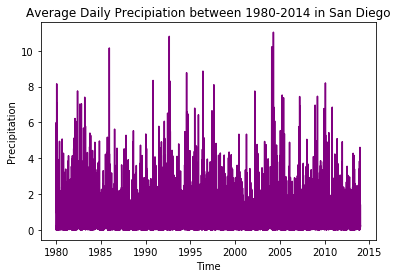

In [25]:
x = np.linspace(1980,2014,12784)
plt.plot(x,recon3[1477:1610,3:].mean(axis=0),ls="-",color='purple' )
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title("Average Daily Precipiation between 1980-2014 in San Diego")
plt.show()

# Visualization of US Storms and Floods

Preparing Plot Functions

In [26]:
class nlcmap(object):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.transformed_levels = np.linspace(0.0, self.levmax,
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap(yi / self.levmax, alpha)

In [27]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
      colors in RGB and hex form for use in a graphing function
      defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
            "r":[RGB[0] for RGB in gradient],
            "g":[RGB[1] for RGB in gradient],
            "b":[RGB[2] for RGB in gradient]}

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
      two hex colors. start_hex and finish_hex
      should be the full six-digit color string,
      inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)


def polylinear_gradient(colors, n):
    ''' returns a list of colors forming linear gradients between
        all sequential pairs of colors. "n" specifies the total
        number of desired output colors '''
    # The number of colors per individual linear gradient
    n_out = int(float(n) / (len(colors) - 1))
    # returns dictionary defined by color_dict()
    gradient_dict = linear_gradient(colors[0], colors[1], n_out)

    if len(colors) > 1:
        for col in range(1, len(colors) - 1):
            next = linear_gradient(colors[col], colors[col+1], n_out)
            for k in ("hex", "r", "g", "b"):
                # Exclude first point to avoid duplicates
                gradient_dict[k] += next[k][1:]

    return gradient_dict

In [28]:
cd = polylinear_gradient(('#e0e0e0','#9aa4e3','#4656bd','#3dff71',"#f2ff3d",'#ffab3d',
 "#d6660b","#d60b0b",'#c70a0a','#a11212',"#750505","#420303",'#290202'), 500)

colorlist = cd['hex']
colmap = matplotlib.colors.ListedColormap(colorlist)

<b> Texas Storm of 1998

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



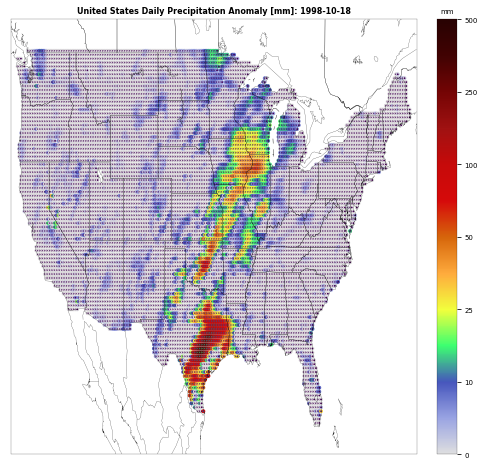

In [37]:
daynum=6868
day=list(recon3[:,daynum])
#Changing the thickness of the line  
rc('axes', linewidth=0.2)
plt.figure(figsize=(8,8))

#preparing plot 
m = Basemap(projection='cyl',llcrnrlat=min(recon3[:,1])-2,urcrnrlat=max(recon3[:,1])+2,\
llcrnrlon=min(recon3[:,2])-1,urcrnrlon=max(recon3[:,2])+1,resolution='l', fix_aspect=False)


levels = [0,10,25,50,100,250,500]
cmap_nonlin = nlcmap(colmap, levels)

m.drawstates(linewidth=0.2)
m.drawcountries(linewidth=0.2)
m.drawcoastlines(linewidth=0.2)

#Inserting data into Base Coordinated
m.scatter(list(recon3[:,2]),list(recon3[:,1]),c=day, s=8, vmin=0, vmax=500,
         edgecolors=cmap_nonlin(day))


#for the colorbar we map the original colormap, not the nonlinear one:
sm = plt.cm.ScalarMappable(cmap=colmap,
                norm=plt.Normalize(vmin=0, vmax=500))
sm._A = []

#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb = m.colorbar(sm, location='right',pad='5%')

#setting the title of the colorbar and fontsize
clb.ax.set_title('mm', fontsize=7)
clb.ax.tick_params(labelsize=7) 


#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb.set_ticks(cmap_nonlin.transformed_levels)
clb.set_ticklabels([lev for lev in levels])

#Modifing the plot
plt.title("United States Daily Precipitation Anomaly [mm]: "+ colnames[daynum], fontsize=8, fontweight='bold')
plt.show()

<b> Hurrican Katrina in 2005

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



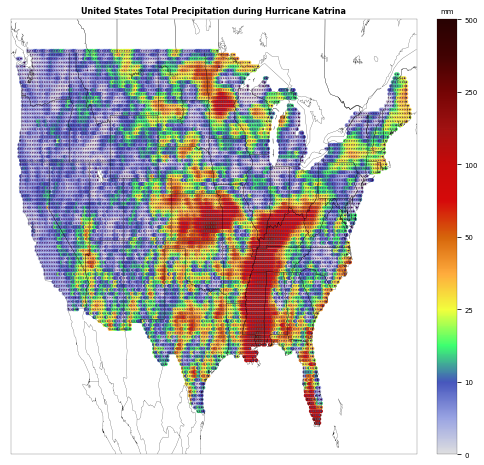

In [35]:
day=list(recon3[:,9369:9377].sum(axis=1))
#Changing the thickness of the line  
rc('axes', linewidth=0.2)
plt.figure(figsize=(8,8))

#preparing plot 
m = Basemap(projection='cyl',llcrnrlat=min(recon3[:,1])-2,urcrnrlat=max(recon3[:,1])+2,\
llcrnrlon=min(recon3[:,2])-1,urcrnrlon=max(recon3[:,2])+1,resolution='l', fix_aspect=False)


levels = [0,10,25,50,100,250,500]
cmap_nonlin = nlcmap(colmap, levels)

m.drawstates(linewidth=0.2)
m.drawcountries(linewidth=0.2)
m.drawcoastlines(linewidth=0.2)

#Inserting data into Base Coordinated
m.scatter(list(recon3[:,2]),list(recon3[:,1]),c=day, s=8, vmin=0, vmax=500,
         edgecolors=cmap_nonlin(day))


#for the colorbar we map the original colormap, not the nonlinear one:
sm = plt.cm.ScalarMappable(cmap=colmap,
                norm=plt.Normalize(vmin=0, vmax=500))
sm._A = []

#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb = m.colorbar(sm, location='right',pad='5%')

#setting the title of the colorbar and fontsize
clb.ax.set_title('mm', fontsize=7)
clb.ax.tick_params(labelsize=7) 


#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb.set_ticks(cmap_nonlin.transformed_levels)
clb.set_ticklabels([lev for lev in levels])

#Modifing the plot
plt.title("United States Total Precipitation during Hurricane Katrina", fontsize=8, fontweight='bold')
plt.show()

<b> Hurrican Andrew of 1992

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

/Users/brianaramirez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



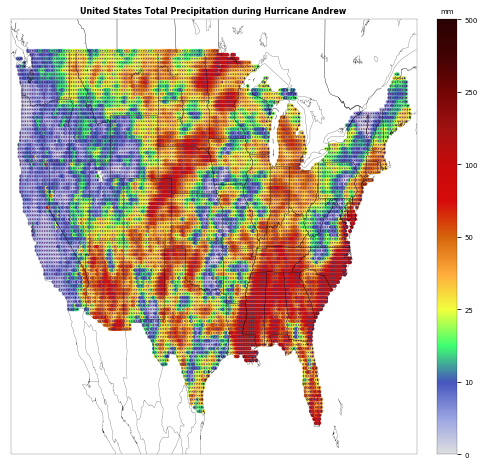

In [36]:
daynum=4614
day=list(recon3[:,daynum:4627].sum(axis=1))
rc('axes', linewidth=0.2)
plt.figure(figsize=(8,8))

#preparing plot 
m = Basemap(projection='cyl',llcrnrlat=min(recon3[:,1])-2,urcrnrlat=max(recon3[:,1])+2,\
llcrnrlon=min(recon3[:,2])-1,urcrnrlon=max(recon3[:,2])+1,resolution='l', fix_aspect=False)


levels = [0,10,25,50,100,250,500]
cmap_nonlin = nlcmap(colmap, levels)

m.drawstates(linewidth=0.2)
m.drawcountries(linewidth=0.2)
m.drawcoastlines(linewidth=0.2)

#Inserting data into Base Coordinated
m.scatter(list(recon3[:,2]),list(recon3[:,1]),c=day, s=8, vmin=0, vmax=500,
         edgecolors=cmap_nonlin(day))


#for the colorbar we map the original colormap, not the nonlinear one:
sm = plt.cm.ScalarMappable(cmap=colmap,
                norm=plt.Normalize(vmin=0, vmax=500))
sm._A = []

#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb = m.colorbar(sm, location='right',pad='5%')

#setting the title of the colorbar and fontsize
clb.ax.set_title('mm', fontsize=7)
clb.ax.tick_params(labelsize=7) 


#here we are relabel the linear colorbar ticks to match the nonlinear ticks
clb.set_ticks(cmap_nonlin.transformed_levels)
clb.set_ticklabels([lev for lev in levels])

#Modifing the plot
#plt.subplot(figsize=(20,20))
plt.title("United States Total Precipitation during Hurricane Andrew", fontsize=8, fontweight='bold')
plt.show()